tutorial: https://ucdavis-bioinformatics-training.github.io/2018-June-RNA-Seq-Workshop/thursday/DE.html

## Load the necessary libraries

In [1]:
library("tidyverse")
library('RColorBrewer')
library('ggrepel')
library("pheatmap")
library('ggplot2')
library('dplyr')
library('ggfortify')
library('limma')
library('edgeR')


── Attaching packages ──────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Load files

## Load RNAseq counts


In [11]:
RECIST_counts <- read.csv(file = './../../data-lab5/011121_RNAseq/countsMatrix2_all_batchAdjusted_labelCorrected.csv',row.names = 1, header= F)

In [12]:
sample_names <- RECIST_counts[1,] %>% t() %>% as.vector
RECIST_counts <- RECIST_counts[-1,]
colnames(RECIST_counts) <- sample_names
RECIST_counts <- RECIST_counts %>% mutate_if(is.character,as.numeric)

In [13]:
head(RECIST_counts)

,98_S1,491_S2,508_S3,590_S4,603_S5,808_S6,854_S7,856_S8,856_S9,873_S10,⋯,252_R21,272_R22,406_R26,422_R27,491_R29,623_R36,333_R25,422_R28,NN_R41,NN_R42
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003,148,182,228,13,63,113,289,121,70,23,⋯,96,141,66,91,77,154,29,18,252,163
ENSG00000000005,0,0,0,0,0,6,0,1,0,0,⋯,1,0,0,0,3,54,0,1,3,3
ENSG00000000419,133,109,107,9,38,41,44,120,65,23,⋯,65,112,68,129,73,90,32,5,216,146
ENSG00000000457,119,67,112,4,47,27,31,63,49,21,⋯,64,105,113,126,77,65,52,11,122,71
ENSG00000000460,92,82,61,12,16,9,9,15,5,10,⋯,32,42,39,30,45,18,15,4,70,40
ENSG00000000938,2,18,4,17,32,4,12,2,3,16,⋯,46,88,4,90,19,60,22,8,34,43


## Load annotation

In [14]:
RECIST_annotation <- read.csv(file = './../../data-lab5/cohort_master/cohort_master_annotation072721.csv', header= T)
have_response <- complete.cases(RECIST_annotation[, 'response_short'])


In [15]:
RECIST_annotation <- RECIST_annotation[have_response,] %>% 
    filter(rna_sampleID!= "") %>% 
    filter(bulkRNA_quality_group != "Bad" & bulkRNA_quality_group != "?" ) %>%
    filter(normal_primary != "normal") 

## Select samples

In [16]:
RECIST_annotation <- RECIST_annotation %>%
    filter(treatment_group == "ICI_PD1" | treatment_group == "ICI_PDL1" |
    treatment_group == "ICI_CTLA4" | treatment_group == "ICI_combo")

# RECIST_annotation <- RECIST_annotation %>%
#     filter(treatment_group == "targeted" | treatment_group == "targeted_plus_ICI")

In [17]:
RECIST_annotation <- RECIST_annotation %>% 
    select(c("rna_sampleID", "age", "sex", "subtype",
                                 "treatment_group", "state", "response_short",
                                 "tissue")) %>%
    column_to_rownames('rna_sampleID')

In [18]:
RECIST_annotation

,age,sex,subtype,treatment_group,state,response_short,tissue
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
307_A1,80,F,cutaneous,ICI_PD1,POST,R,skin
406_A3,70,M,cutaneous,ICI_PD1,POST,PD,skin
620_A7,54,F,cutaneous,ICI_PD1,PRE,PD,liver
854_S7,63,F,uveal,ICI_combo,PRE,PD,liver
856_S8,74,M,cutaneous,ICI_PD1,PRE,PD,skin
856_S9,74,M,cutaneous,ICI_PD1,PRE,PD,skin
879_S11,69,M,acral,ICI_combo,PRE,R,skin
920_S13,61,M,cutaneous,ICI_combo,PRE,PD,brain
926_A12,62,M,cutaneous,ICI_PD1,PRE,PD,skin


In [19]:
counts <- RECIST_counts[rownames(RECIST_annotation)]


## change to gene symbol


In [20]:
gene_sym <- read.csv(file =  './../../data-lab5/011121_RNAseq/analysisReady/Ensembl_HGNC_map.csv')


In [21]:
counts<-counts %>%
    rownames_to_column('row') %>%
    left_join(gene_sym, by = c("row" = "row")) %>%
    drop_na(hgnc_symbol)%>% 
    column_to_rownames('hgnc_symbol') %>%
    select(-row)

# Preprocessing

In [22]:
# Create DGEList object
d0 <- DGEList(counts)

In [23]:
# Calculate normalization factors (Note: calcNormFactors doesn’t normalize the data, 
#it just calculates normalization factors for use downstream.

d0 <- calcNormFactors(d0)


## filter genes

In [24]:
# remove lowly expressed genes
# lowExp <- which(apply(cpm(d0), 1, mean) < 4)
# d <- d0[-lowExp,] 

keep <- rowSums(cpm(d0)>10) >= 14
d <- d0[keep,]

# remove low variance genes
# lowVar <- which(apply(cpm(d0), 1, var) < 1)
# d <- d[-lowVar,] 

nrow(d) # number of genes left

[1] 10782

# QC

## create variables

In [25]:
group <- factor(RECIST_annotation$response_short)
age <- RECIST_annotation$age
sex <- factor(RECIST_annotation$sex)
state <- factor(RECIST_annotation$state)
treatment_group <- factor(RECIST_annotation$treatment_group)
tissue <- factor(RECIST_annotation$tissue)

## check distribution of counts

In [26]:
logcpm <- cpm(d$counts, log=TRUE)

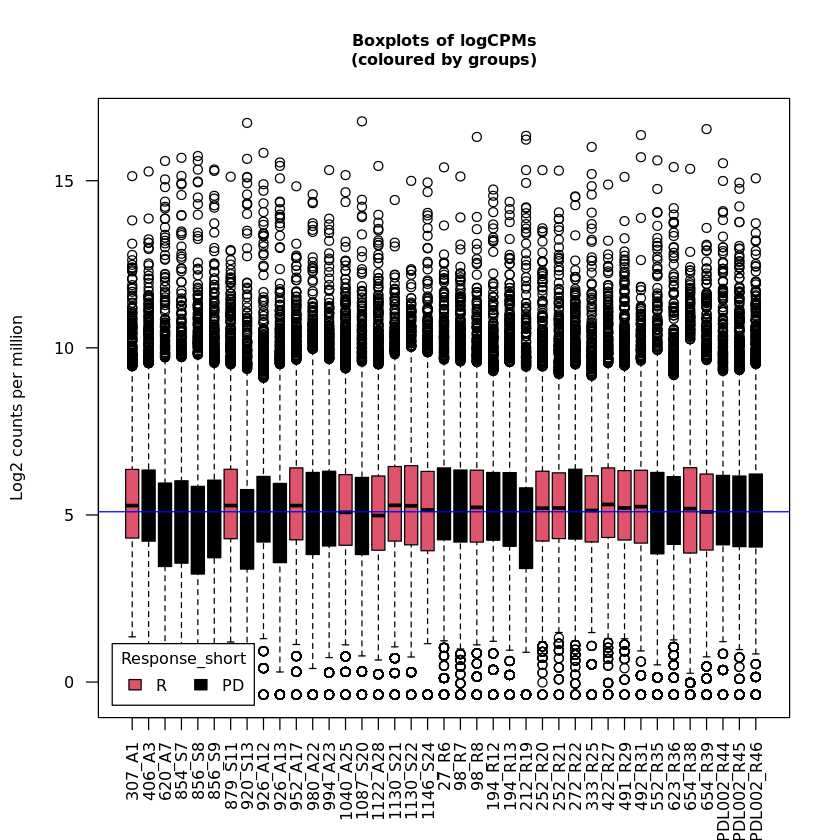

In [18]:
# pdf(file = './../../data-lab5/cohort_master/LimmaVoom_result/Boxplot_logCPM_allICI_072121.pdf', width = 14,height = 4)


boxplot(logcpm, xlab="", ylab="Log2 counts per million",las=2,col=group,
        pars=list(cex.lab=0.8,cex.axis=0.8))
abline(h=median(logcpm),col="blue")
title("Boxplots of logCPMs\n(coloured by groups)",cex.main=0.8)

legend("bottomleft", inset=.02, title="Response_short",
   c("R", "PD"), fill=group[1:2], horiz=TRUE, cex=0.8)

# dev.off()

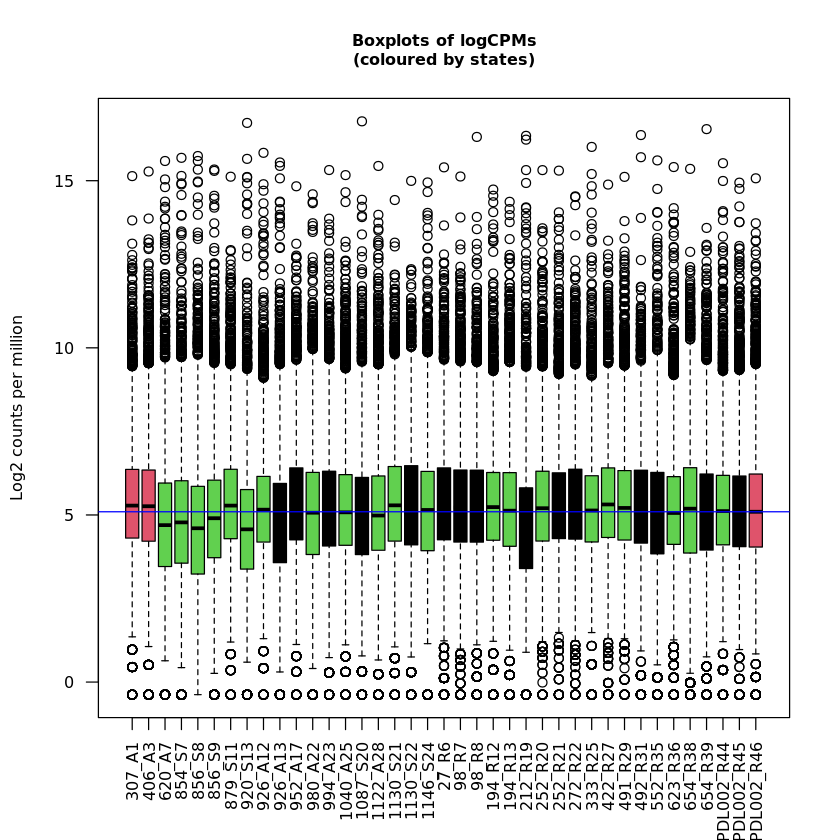

In [19]:
boxplot(logcpm, xlab="", ylab="Log2 counts per million",las=2,col=state,
        pars=list(cex.lab=0.8,cex.axis=0.8))
abline(h=median(logcpm),col="blue")
title("Boxplots of logCPMs\n(coloured by states)",cex.main=0.8)

## MDS

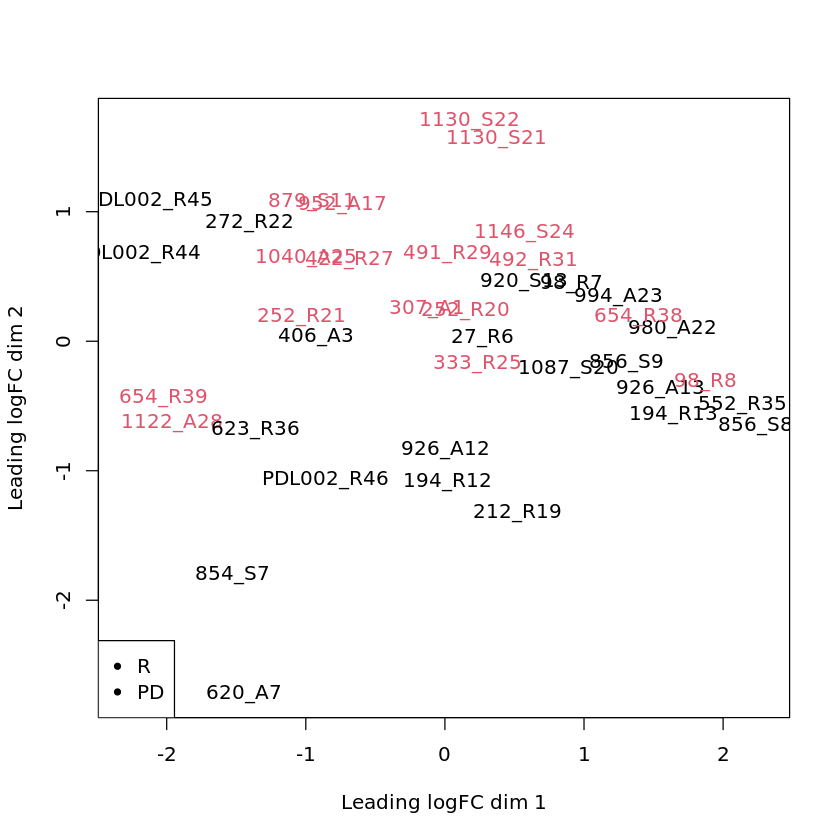

In [20]:
plotMDS(d, col = as.numeric(group))
legend("bottomleft", as.character(unique(group)), pch=20)


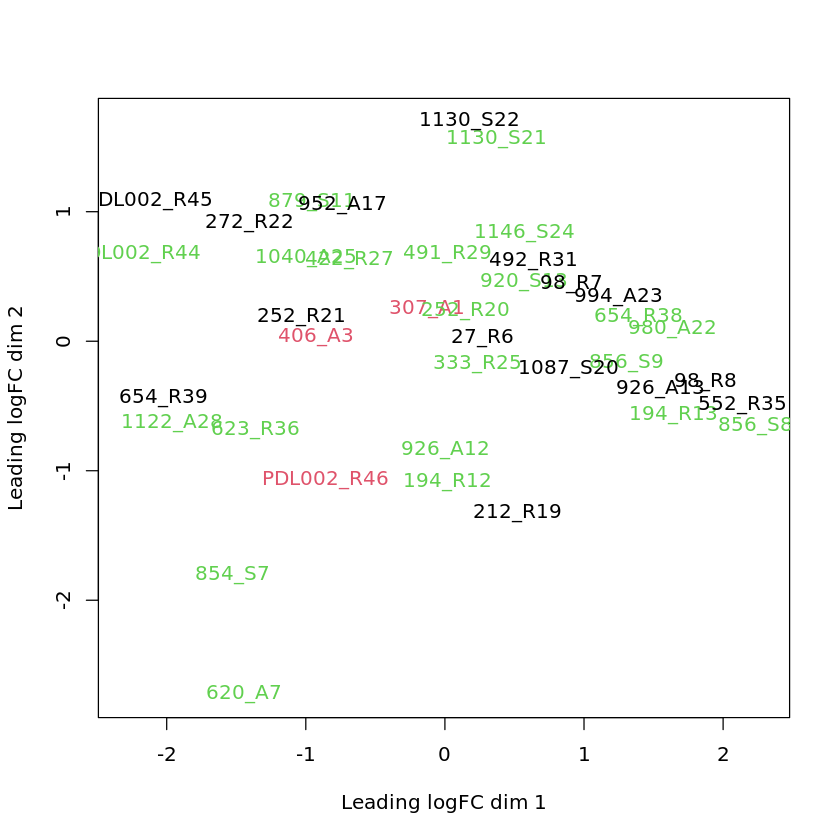

In [21]:
plotMDS(d, col = as.numeric(factor(RECIST_annotation$state)))


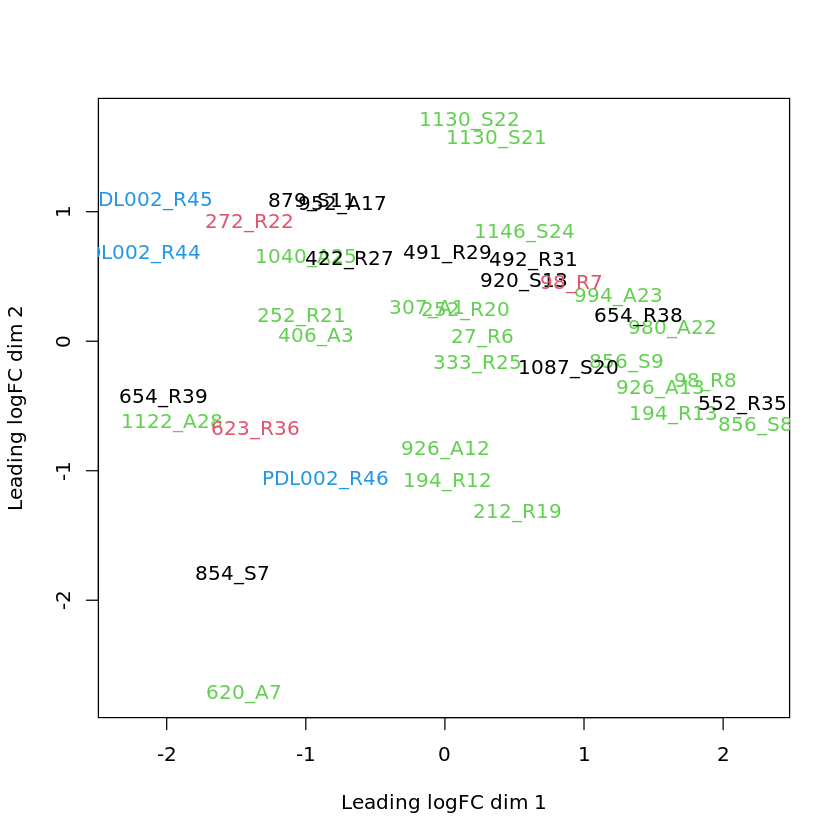

In [22]:

plotMDS(d, col = as.numeric(factor(RECIST_annotation$treatment_group)))


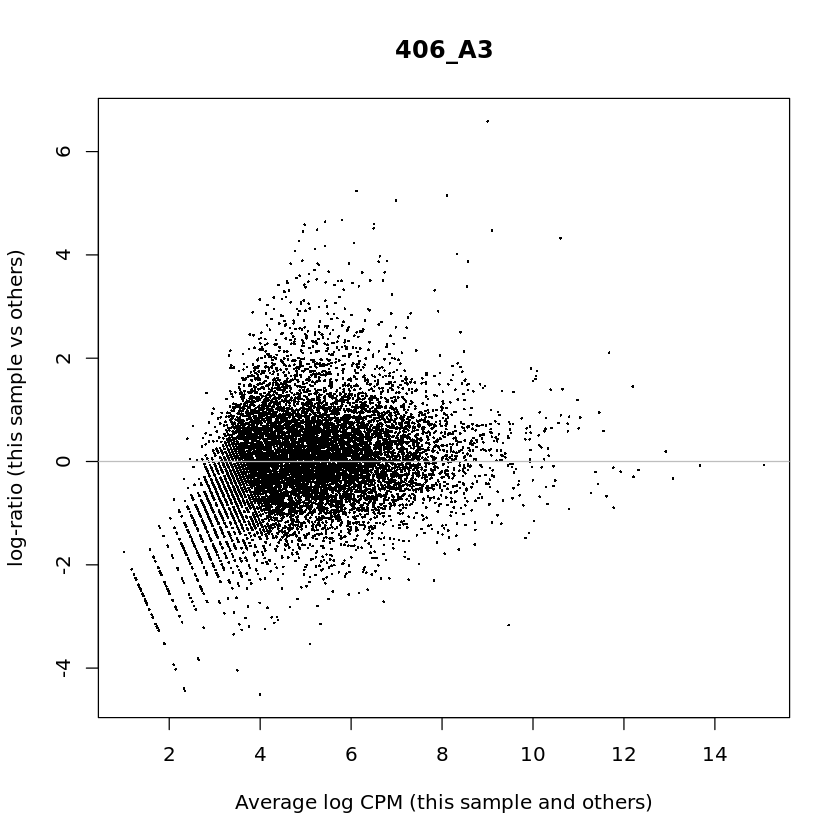

In [23]:
plotMD(d,column = 2)
abline(h=0,col="grey")

# Voom transformation and calculation of variance weights

In [31]:
# design
mm <- model.matrix(~0 + group+state+treatment_group+sex+tissue + age)

What is voom doing?

- Counts are transformed to log2 counts per million reads (CPM), where “per million reads” is defined based on the normalization factors we calculated earlier
- A linear model is fitted to the log2 CPM for each gene, and the residuals are calculated
- A smoothed curve is fitted to the sqrt(residual standard deviation) by average expression (see red line in plot above)
- The smoothed curve is used to obtain weights for each gene and sample that are passed into limma along with the log2 CPMs.

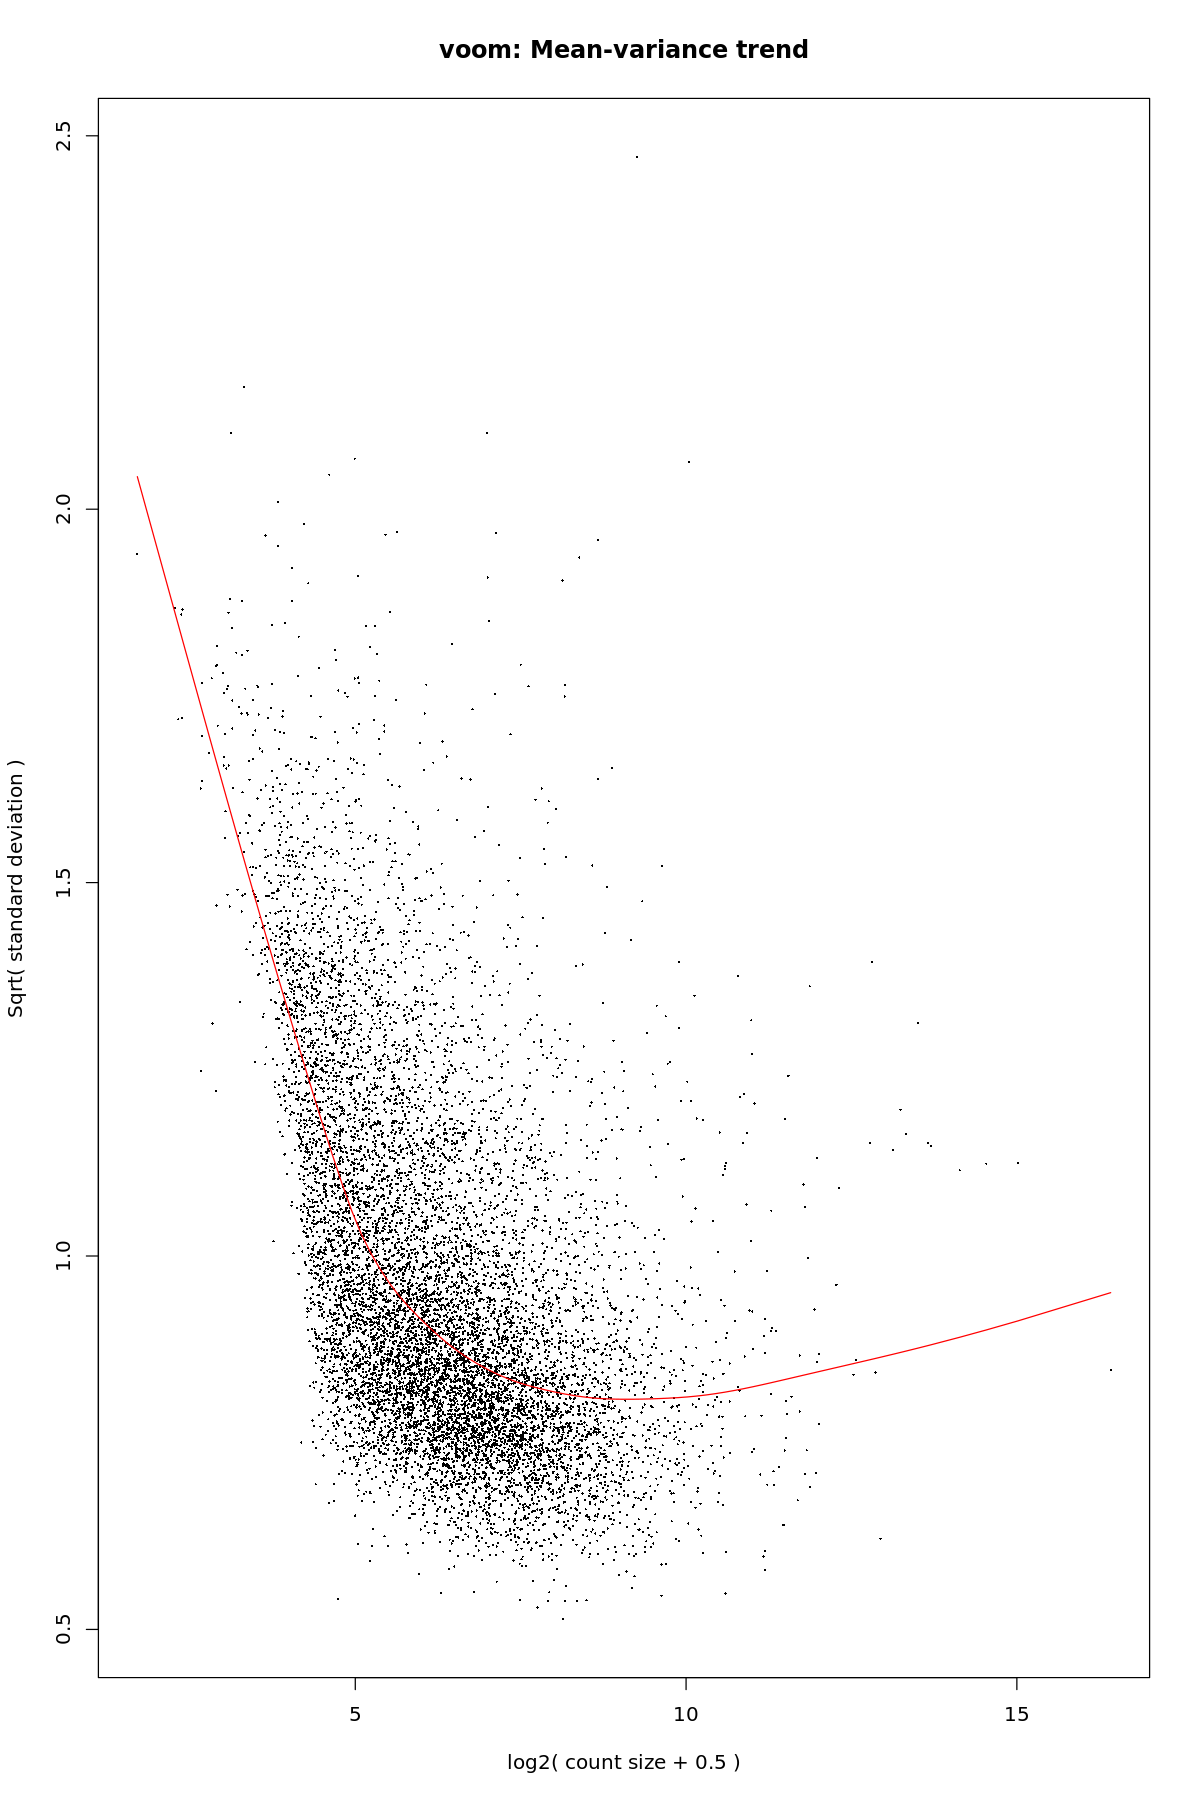

In [32]:

y <- voom(d, mm, plot = T)


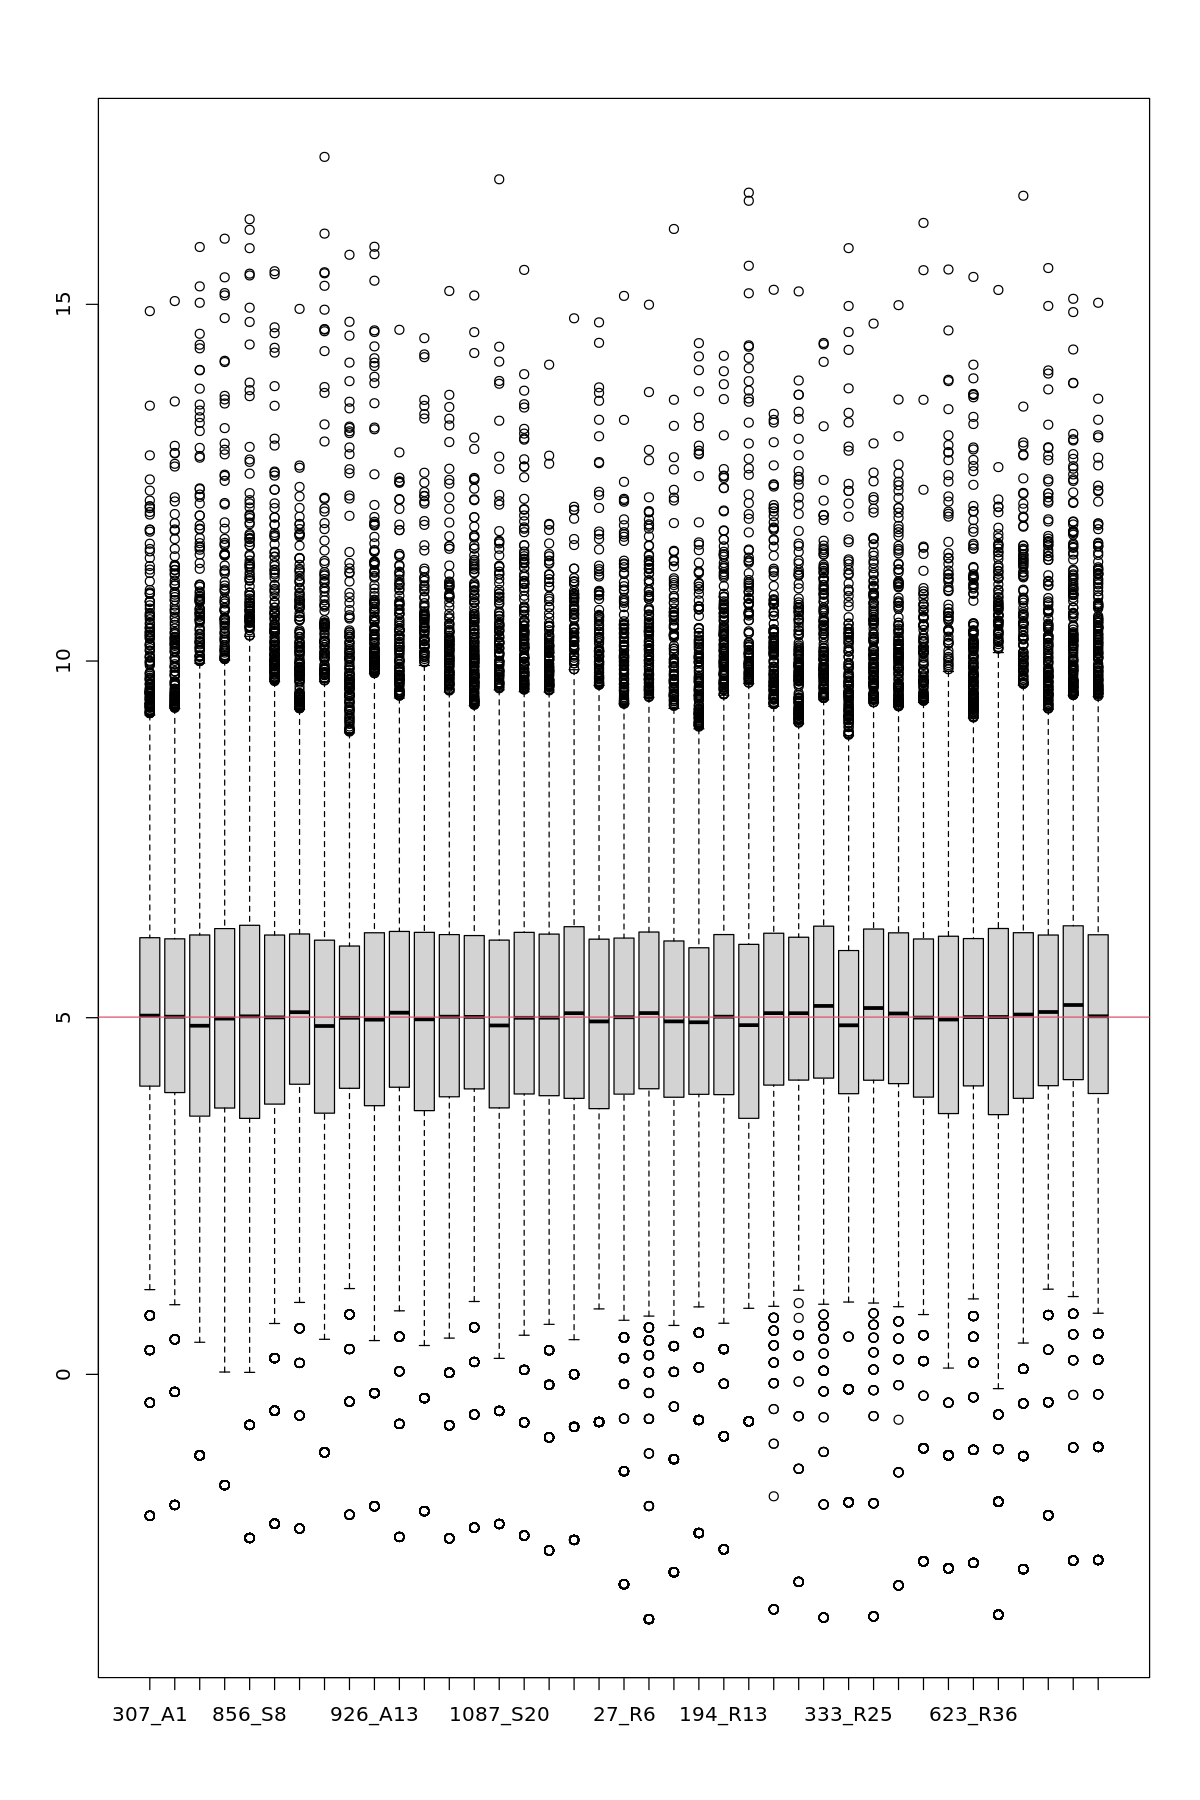

In [45]:
boxplot(y$E)
abline(h=median(y$E),col=2)

# Fitting linear models in limma


In [46]:
fit <- lmFit(y, mm)


In [47]:
head(coef(fit), 20)

,groupPD,groupR,statePOST,statePRE,treatment_groupICI_CTLA4,treatment_groupICI_PD1,treatment_groupICI_PDL1,sexM,tissuebone,tissuebrain,tissueliver,tissuelymph,tissueskin,tissuesmall_intestine,age
TSPAN6,4.086329,3.369803,0.11496509,0.561409295,0.7612449,0.20237900,-0.15581094,-0.005288788,-0.722033096,-1.05836442,2.1119137,-0.26068218,-0.548833422,0.625128175,1.334528e-02
DPM1,4.593432,4.467924,0.43344888,0.062936678,-0.1411995,0.21090686,0.09449977,0.154737816,0.600137407,0.37917277,0.3699825,0.01517378,-0.007354911,0.112981458,-5.809644e-03
SCYL3,6.521327,5.941723,-0.12066508,-0.039327611,-0.7565575,-0.27617083,-0.94792513,-0.308331898,-0.344289238,-1.99114666,-0.9397593,-0.48543438,-0.474783183,-0.445044714,-9.601185e-03
C1orf112,4.489300,3.843946,-0.09223047,-0.240229941,-0.5411309,0.09326905,-0.94277555,-0.375969339,-0.657174207,0.37811898,-0.9242321,0.09843494,-0.429851283,0.001409119,-1.515898e-03
CFH,6.363604,7.894013,0.93135349,-0.705670582,1.4952393,0.54722536,4.81799835,0.810586273,2.754462827,0.35925106,7.8365577,1.95901836,1.326388683,0.969997174,-3.886854e-02
FUCA2,3.621288,3.549036,-0.07548242,0.369910113,0.2652131,-0.14348957,0.60422048,0.242830963,0.001471593,-1.12857576,1.1083967,0.72292280,0.617382788,0.626166288,4.571900e-03
GCLC,6.008792,5.581938,0.08495501,0.306559249,-1.1401921,-0.34469166,0.08707617,-0.057785754,0.705564025,-0.38039247,2.0094427,-0.24151824,-0.036910117,-0.431073957,-1.359687e-02
NFYA,7.000949,5.930994,-0.03221990,0.223396778,-0.3509362,-0.32128292,-1.21964621,-0.275405826,-0.077897857,-0.87770634,-1.6740419,0.67045487,-0.203693008,0.286080048,-7.106328e-05
NIPAL3,1.336516,1.617404,0.38341941,0.552920853,-0.1349990,-0.21939837,-0.44411143,0.748186314,-1.005857450,-0.12606293,0.9317696,0.69247357,1.390601196,-0.352674364,2.943331e-02
LAS1L,6.225814,6.029230,-0.15238624,-0.245296339,-0.6525492,-0.21197339,-0.40366754,0.481811765,0.416332986,-0.22072276,-0.3903119,-0.19418585,-0.112953647,-0.302673295,2.050998e-03


In [48]:
# Specify which groups to compare:

contr <- makeContrasts(groupR - groupPD, levels = colnames(coef(fit)))

In [49]:
# Estimate contrast for each gene

tmp <- contrasts.fit(fit, contr)
tmp <- eBayes(tmp)


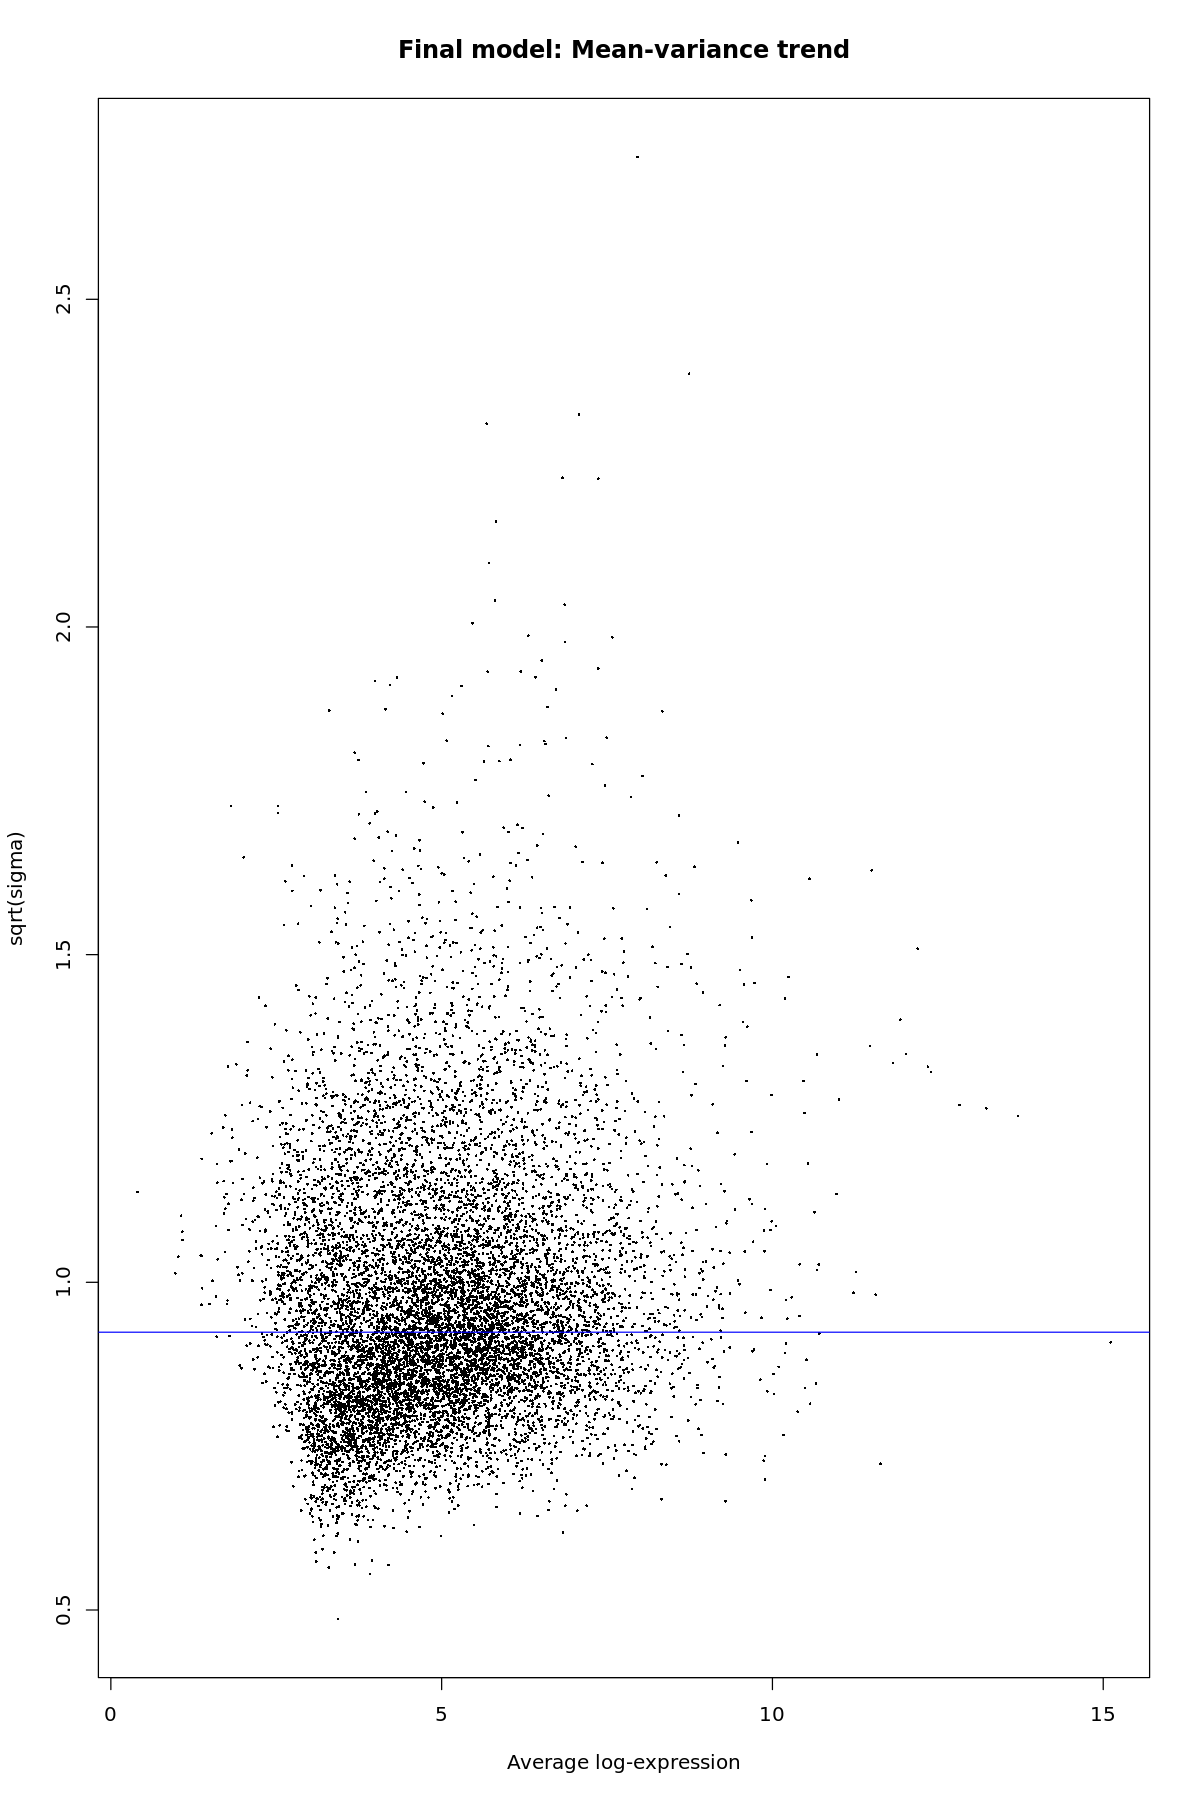

In [50]:
plotSA(tmp, main="Final model: Mean-variance trend")


In [51]:
top.table <- topTable(tmp, sort.by = "P", n = Inf)
head(top.table, 20)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FCGR3A,2.180290,5.990836,6.106841,1.163700e-06,0.003134943,5.507010
BTN3A3,2.033176,5.227917,6.104240,1.172036e-06,0.003134943,5.498580
TM4SF1,3.003900,4.795294,6.073436,1.275447e-06,0.003134943,5.382979
SERPINA1,4.403378,6.001913,5.992244,1.594400e-06,0.003134943,5.202362
TLR1,2.004683,3.085843,5.985980,1.622128e-06,0.003134943,4.758409
MSR1,2.654512,5.798520,5.959555,1.744543e-06,0.003134943,5.122625
ADPRH,2.744810,2.553423,5.783322,2.837311e-06,0.003581004,3.873034
SRGN,2.322007,5.059562,5.737540,3.220400e-06,0.003581004,4.542936
LAPTM5,2.483877,5.988681,5.687118,3.702913e-06,0.003581004,4.406037


In [52]:
result <- top.table %>% rownames_to_column("row")
colnames(result) <- c("row", "log2FoldChange", "baseMean", "t", "pvalue", "padj", "B")

## save result

In [72]:
# readr::write_csv(result, file='./../../data-lab5/cohort_master/LimmaVoom_result/ICI_R_v_PD_ageAdjustedresult081321.csv')

In [2]:
result <- readr::read_csv( file='./../../data-lab5/cohort_master/LimmaVoom_result/ICI_R_v_PD_ageAdjustedresult081321.csv')


── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  row = col_character(),
  log2FoldChange = col_double(),
  baseMean = col_double(),
  t = col_double(),
  pvalue = col_double(),
  padj = col_double(),
  B = col_double()
)




# DEG analysis

## volcano plot

In [3]:
### Set thresholds
padj.cutoff <- 0.05
lfc.cutoff <- 1.58
#The lfc.cutoff is set to 0.58; translates to an actual fold change of 1.5 
sig_genes <- result %>%
  data.frame() %>%
  dplyr::filter(padj < padj.cutoff & abs(log2FoldChange) > lfc.cutoff) %>%
  dplyr::arrange(desc(log2FoldChange))

In [4]:
result[result$row =='IL18',]

row,log2FoldChange,baseMean,t,pvalue,padj,B
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IL18,1.932743,3.074347,3.791891,0.0006974903,0.03008136,-0.392128


In [6]:
sig_genes %>% arrange(log2FoldChange)

row,log2FoldChange,baseMean,t,pvalue,padj,B
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MTCO3P12,-3.657726,3.918457,-3.631545,1.071039e-03,0.037489065,-0.80041514
MT-ND6,-3.083777,7.132081,-4.145433,2.670621e-04,0.021482090,0.31842049
MT-ND4L,-3.024045,9.203624,-5.530424,5.718881e-06,0.003581004,3.97475413
MTND1P23,-2.995655,5.129584,-4.953438,2.850637e-05,0.008574792,2.50191451
MTCO1P12,-2.952987,5.905263,-4.824208,4.085486e-05,0.009130306,2.15141190
MT-CO2,-2.496684,11.935279,-4.205970,2.262185e-04,0.019514323,0.51763170
PRTG,-2.483913,3.530810,-3.715348,8.564635e-04,0.034456678,-0.57641885
MTND2P28,-2.476057,7.818408,-4.232211,2.104898e-04,0.019071436,0.53251163
CDCA7,-2.462668,3.583792,-3.456202,1.702061e-03,0.046133750,-1.17974458


## Volcano plot

In [7]:
vocano_df <- result %>% column_to_rownames('row')

#color DEG
vocano_df$diffexpressed <- "NO"
vocano_df$diffexpressed[vocano_df$log2FoldChange > lfc.cutoff & vocano_df$padj < padj.cutoff] <- "UP"
vocano_df$diffexpressed[vocano_df$log2FoldChange < -lfc.cutoff & vocano_df$padj < padj.cutoff] <- "DOWN"

vocano_df$delabel <- NA
vocano_df$delabel[vocano_df$diffexpressed != "NO"] <- rownames(vocano_df)[vocano_df$diffexpressed != "NO"]



Warning message:
“Removed 10533 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 193 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


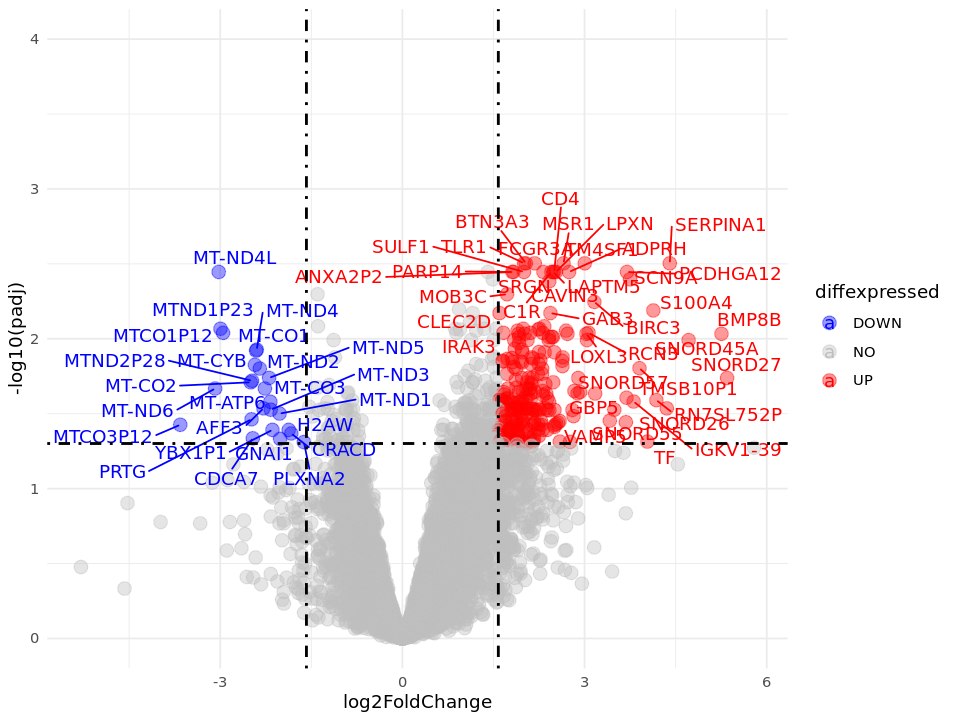

In [9]:
library(ggrepel)
options(repr.plot.width=8, repr.plot.height=6)

# pdf(file = './../../data-lab5/cohort_master/LimmaVoom_result/VocanoPlot_allICI_081321.pdf', width = 6,height = 4)

# plot adding up all layers we have seen so far
ggplot(data=vocano_df, aes(x=log2FoldChange, y=-log10(padj),col=diffexpressed, label=delabel)) +
        geom_point(alpha=0.4, size=3.5) +
        scale_color_manual(values=c("blue", "grey","red"))+       
        theme_minimal() + 
#         theme(text = element_text(size = 20)) +
        geom_text_repel(max.overlaps=40) +
        geom_vline(xintercept=c(-lfc.cutoff,lfc.cutoff),lty=4,col="black",lwd=0.8) +
        geom_hline(yintercept = -log10(padj.cutoff),lty=4,col="black",lwd=0.8)  +
    ylim(0, 4)

# dev.off()

## Heatmap

In [27]:
heatmap_annotation <- RECIST_annotation %>% 
    select(age,sex, tissue,state, treatment_group, response_short)

In [28]:
col_order <- heatmap_annotation %>% 
    arrange(response_short, match(state, c("PRE", "ON", "POST")),treatment_group,) %>% rownames()

In [29]:
anno_col = list(response_short = c(PD = "salmon", R = "lightgreen"), 
    treatment_group = c(ICI_PD1 = 'cyan', ICI_combo = 'steelblue1', ICI_CTLA4 = 'mediumblue', ICI_PDL1 = 'lightslateblue'),
     sex = c(M = 'lightblue2', F = 'mistyrose'), 
     state = c(PRE = 'lightyellow', ON ='gold1', POST ='sandybrown')     
               )

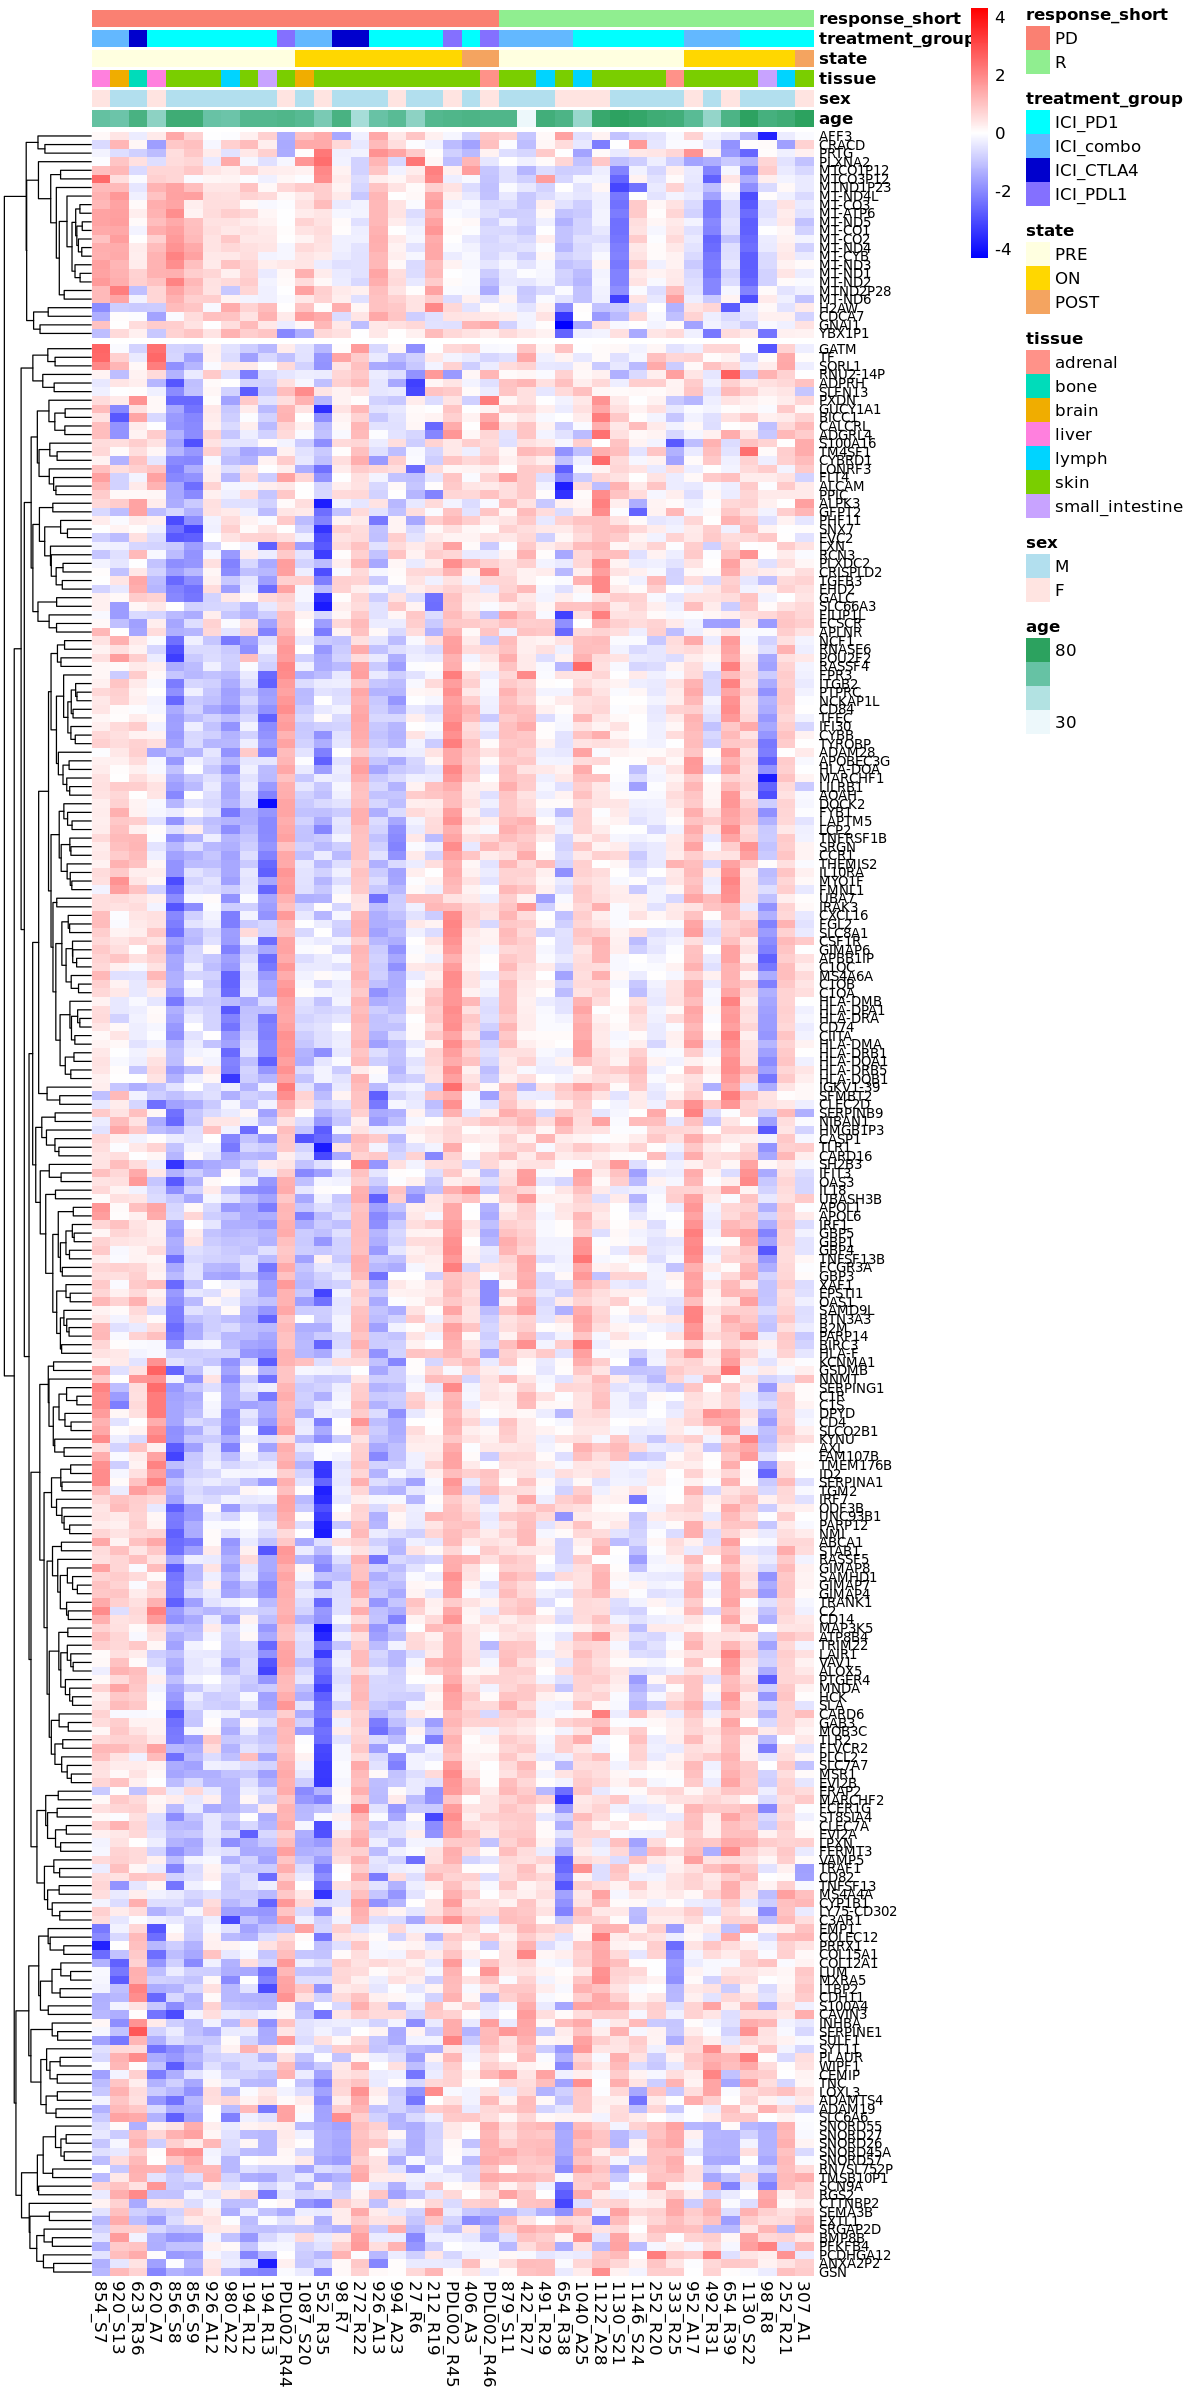

In [34]:
options(repr.plot.width=10, repr.plot.height=20)

pheatmap(y$E[sig_genes$row,col_order],  
            color = colorRampPalette(c("blue","white","red"))(256),
                 annotation_colors =anno_col,
             cluster_rows = T,
             cluster_cols = F,
             show_rownames = T,
             annotation = heatmap_annotation, 
             border_color = NA, 
             fontsize = 10, 
             scale = "row", 
             fontsize_row = 8, 
             height = 7,
             width = 7, 
            cutree_rows = 2,
                 gaps_row = 5,
#             filename = './../../data-lab5/cohort_master/LimmaVoom_result/heatmapDEG_allICI_081321.pdf'
        )

# gene set profiles

In [29]:
subtype_signature <- read.csv(file = './../../data-lab5/Jerby-Arnon/TableS3B_denovo.cell.subtype.sig.csv', header= T)


In [101]:
head(subtype_signature)

,B.CELL,CAF,ENDOTHELIAL,MACROPHAGE,MALIGNANT,NK,T.CD4,T.CD8,T.CELL,STROMA,IMMUNE,T.CD4.EXHAUSTED,T.CD4.NAIVE,T.CD4.TREG,T.CD8.CYTOTOXIC,T.CD8.EXHAUSTED,T.CD8.NAIVE
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ADAM19,ABCA6,A2M,ABCA1,AASDHPPT,ALOX5AP,AIM1,ADORA2A,ARHGEF1,A4GALT,ACAP1,C9orf16,ABLIM1,ARID3B,APOBEC3C,ABCC9,ATM
2,ADAM28,ABCA8,ABCD4,ABI1,AATF,APMAP,AQP3,ASB2,ASB2,ADAMTS1,AKNA,CDK5R1,ATM,CARD16,B2M,AKAP5,ATXN7
3,AFF3,ABI3BP,ADAM15,ACAA1,ACN9,CALM1,BCL11B,ASXL2,ATHL1,ADAMTSL1,ALOX5AP,CTLA4,CAMK4,CCR4,CCL3,ANKLE1,CAMK4
4,ATF7IP,ACTA2,ADAMTS9,ACER3,ACOT7,CD160,CAMK4,CBLB,BCL11B,ADIRF,ANKRD44,DDX5,CCR7,CCR8,CCL4,AP4B1-AS1,CCR7
5,BACH2,ACVR1,ADCY4,ACP2,ACSL3,CD244,CCR4,CCDC141,C16orf54,ANGPTL2,APOBEC3G,HLA-J,EEF1A1,CD177,CCL5,APOBEC3A,EEF1A1
6,BANK1,ADAM12,ADM5,ACP5,ADIPOR1,CD247,CCR8,CCDC64,CASP8,APP,ARHGAP15,ICA1,EEF1B2,DDX60,CSF1,ARHGEF26-AS1,FAM102A


In [32]:
get_unique_genes <- function(subtype_signature, celltype){
    other_subtype <- subtype_signature %>% select(-celltype) %>%
        as.matrix() %>%
        as.vector() 
    setdiff(subtype_signature[,celltype], other_subtype)
    }

In [52]:
B_signature <- intersect(get_unique_genes(subtype_signature,"B.CELL"), rownames(y$E))
NK_signature <- intersect(get_unique_genes(subtype_signature,"NK"), rownames(y$E))
MACROPHAGE_signature <- intersect(get_unique_genes(subtype_signature,"MACROPHAGE"), rownames(y$E))

In [70]:
cellType_signature <- c(B_signature, NK_signature, MACROPHAGE_signature)

In [71]:

cellType_annotation <- data_frame(row = cellType_signature, cellType= NA) %>%
    column_to_rownames("row")
cellType_annotation[B_signature,'cellType'] <- 'B'
cellType_annotation[NK_signature,'cellType'] <- 'NK'
cellType_annotation[MACROPHAGE_signature,'cellType'] <- 'MACROPHAGE'

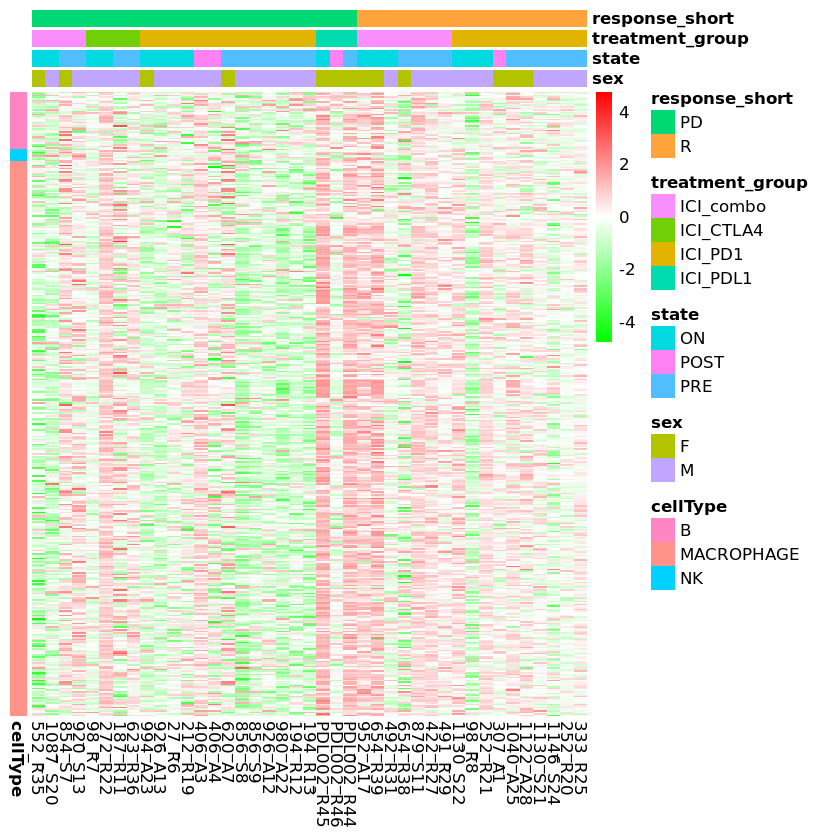

In [77]:
pheatmap(y$E[cellType_signature,col_order],  
            color = colorRampPalette(c("green","white","red"))(256),
             cluster_rows = F,
             cluster_cols = F,
             show_rownames = F,
             annotation_col = heatmap_annotation, 
             annotation_row = cellType_annotation,
             cutree_rows = 3,
             border_color = NA, 
             fontsize = 10, 
             scale = "row", 
             fontsize_row = 8, 
             height = 7,
             width = 7, )

## T cell state genes

In [84]:
cyotoxic_gene <- intersect(rownames(y$E),c('NKG7', 'CCL4', 'CST7', 'PRF1', "GZMA", "GZMB", "INFG", "CCL3"))
exhausted_gene <- intersect(rownames(y$E),c('PD1', 'TIGIT', 'LAG3', 'TIM3', 'CTLA4'))
naive_gene <- intersect(rownames(y$E),c('CCR7', 'TCF7', 'LEF1', 'SELL'))

In [85]:
cellState_gene <- c(cyotoxic_gene, exhausted_gene, naive_gene)

In [86]:
cellState_annotation <- data_frame(row = cellState_gene, cellState= NA) %>%
    column_to_rownames("row")

cellState_annotation[cyotoxic_gene,'cellState'] <- 'cyotoxic'
cellState_annotation[exhausted_gene,'cellState'] <- 'exhausted'
cellState_annotation[naive_gene,'cellState'] <- 'naive'

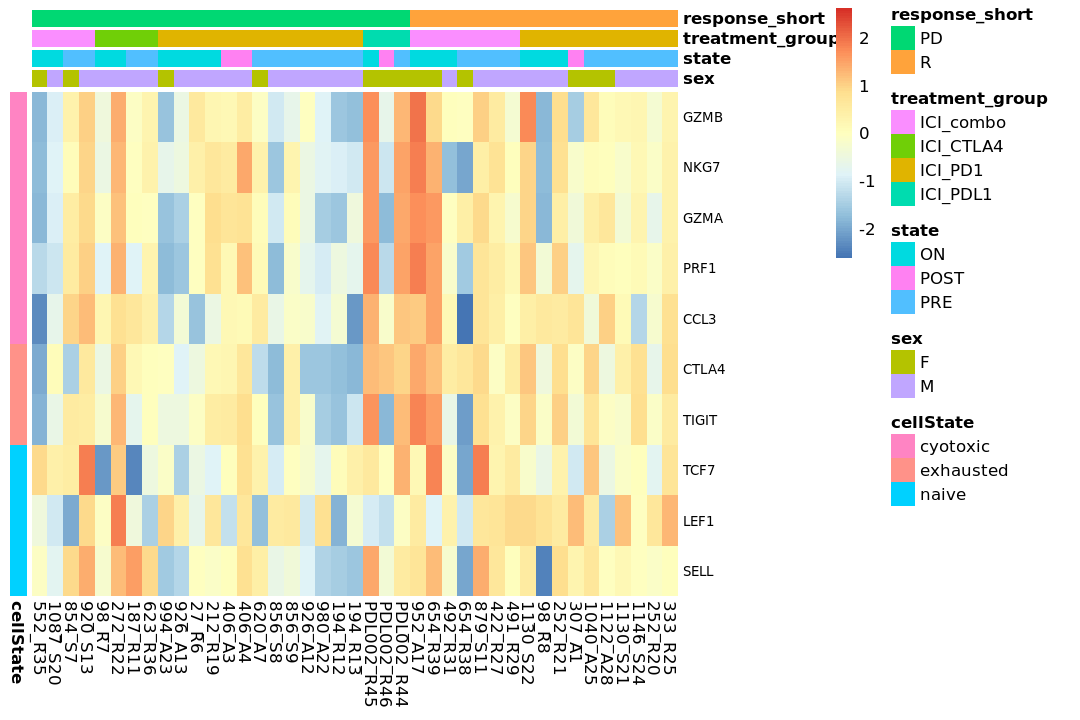

In [94]:
options(repr.plot.width=9, repr.plot.height=6)

pheatmap(y$E[cellState_gene,col_order],  
#             color = colorRampPalette(c("green","white","red"))(256),
             cluster_rows = F,
             cluster_cols = F,
             show_rownames = T,
             annotation_col = heatmap_annotation, 
             annotation_row = cellState_annotation,
             cutree_rows = 3,
             border_color = NA, 
             fontsize = 10, 
             scale = "row", 
             fontsize_row = 8, 
             height = 7,
             width = 14, )

In [100]:
rownames(y$E)[grepl("PD", rownames(y$E))]

[1] "PDK4"        "PDK2"        "NCAPD2"      "RGPD5"       "DEPDC1"     
  [6] "SPDL1"       "H6PD"        "PDIA5"       "PDE4A"       "THUMPD1"    
 [11] "PDZD4"       "PDK3"        "PDCD2"       "PDE8A"       "TPD52"      
 [16] "PDS5B"       "EPDR1"       "PDRG1"       "PDCD7"       "PDPR"       
 [21] "SNRPD3"      "DEPDC5"      "PDGFB"       "TPD52L2"     "MOSPD1"     
 [26] "PDGFRL"      "PDCD5"       "PDAP1"       "IMPDH1"      "MPDZ"       
 [31] "NPDC1"       "PDLIM1"      "CPD"         "PDHX"        "GAPDH"      
 [36] "TPD52L1"     "PDE10A"      "PDE4D"       "GNPDA1"      "PDGFRB"     
 [41] "PDCD10"      "GPD2"        "PDE1A"       "PDCL3"       "CNPPD1"     
 [46] "AMPD2"       "PDZD11"      "PDLIM2"      "PDZRN3"      "PDS5A"      
 [51] "EEPD1"       "PEPD"        "PPDPF"       "SNRPD2"      "GPCPD1"     
 [56] "L3HYPDH"     "MPDU1"       "MOSPD2"      "PDLIM4"      "PDHA1"      
 [61] "PDZD2"       "AMPD3"       "THUMPD3"     "PDGFRA"      "SMPD4"      
 [66] "PDCL"        "THUMPD2"     "ENTPD1"      "HNRNPD"      "PDE5A"      
 [71] "PDPK1"       "SCCPDH"      "PDIA6"       "HSPD1"       "PDGFC"      
 [76] "PDCD11"      "LYPD1"       "PDCD4"       "NKAPD1"      "NCAPD3"     
 [81] "SMPD4BP"     "PDK1"        "PDE3B"       "GPD1L"       "HNRNPDL"    
 [86] "PDLIM3"      "PDIA4"       "PDE6D"       "PTPDC1"      "GDPD5"      
 [91] "PDXK"        "G6PD"        "PDPN"        "PDLIM5"      "PDSS2"      
 [96] "PDP1"        "PDZD8"       "SMPD1"       "PDIA3"       "SNRPD1"     
[101] "ATP5PD"      "PDHB"        "RGPD8"       "PDCD6IP"     "PDGFD"      
[106] "PDE7B"       "PDE3A"       "SMPDL3A"     "PDP2"        "PDE12"      
[111] "PDIK1L"      "IMPDH2"      "PDE4DIP"     "PDXDC1"      "PDIA3P1"    
[116] "RGPD6"       "PDE4B"       "RGPD2"       "ENTPD5"      "PDLIM7"     
[121] "ENTPD4"      "PDGFA"       "ENTPD6"      "ENTPD7"      "PDE7A"      
[126] "THUMPD3-AS1" "PDPR2P"      "CEBPD"       "ENTPD1-AS1"  "PDXP"       
[131] "PDLIM1P4"    "PDCD6"       "PDXDC2P"     "PDE4DIPP2"

## 